This notebook shows how we empirically fit the parameters of a parametric equation to estimate the expected spkd edit distance between a pair of Poisson spike trains, given the (common) firing rate, duration, and cost parameter q.  The parameters were fit to numerically estimated mean spkd values for many different firing rate and cost parameter values.

The separate notebook poissonspkd_reg.ipynb documents validation of the resulting parametric equation using out-of-training-sample test values.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adds parent directory to path

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error, r2_score
import json

# === Load previously numerically estimated data ===
spkd_data = np.load('spkd_poisson_equalized.npz', allow_pickle=True)
firing_rates, cost_values, spkd_per_spike, spkd_per_sec = (spkd_data['firing_rates'],
                                                           spkd_data['cost_values'],
                                                           spkd_data['spkd_per_spike'],
                                                           spkd_data['spkd_per_sec'])

In [2]:
# === Sigmoid function for single firing rate ===
def sigmoid_single(log_cost, alpha, beta, gamma, delta):
    return alpha + beta / (1 + np.exp(-gamma * (log_cost - delta)))


In [3]:
# === Step 1: Fit sigmoid to each firing rate curve ===
params_by_fr = []
log_costs = np.log10(cost_values)

for i, fr in enumerate(firing_rates):
    y = spkd_per_spike[:, i]
    try:
        popt, _ = curve_fit(sigmoid_single, log_costs, y, p0=[0.1, 1.5, 1.0, 2.0],
                            bounds=([0, 0, 0.01, -1], [2.5, 3.0, 20, 6]),
                            maxfev=10000)
    except RuntimeError:
        print(f"FR={fr} failed to converge, using fallback params")
        popt = [np.mean(y), 1.0, 1.0, 2.0]
    params_by_fr.append(popt)

params_by_fr = np.array(params_by_fr)  # shape: (n_FRs, 4)

# === Step 2: Fit polynomials to each parameter as a function of FR ===
frs = firing_rates

alpha_spline = CubicSpline(frs, params_by_fr[:, 0], bc_type='natural')
beta_spline  = CubicSpline(frs, params_by_fr[:, 1], bc_type='natural')
gamma_spline = CubicSpline(frs, params_by_fr[:, 2], bc_type='natural')
delta_spline = CubicSpline(frs, params_by_fr[:, 3], bc_type='natural')

In [4]:
# === Function for predicting using fitted splines ===
def predict_spkd(log_cost, fr):
    a = alpha_spline(fr)
    b = beta_spline(fr)
    g = gamma_spline(fr)
    d = delta_spline(fr)
    return a + b / (1 + np.exp(-g * (log_cost - d)))


In [5]:
np.savez('spkd_spline_fits.npz',
         frs=firing_rates,
         alpha=params_by_fr[:, 0],
         beta=params_by_fr[:, 1],
         gamma=params_by_fr[:, 2],
         delta=params_by_fr[:, 3])


In [6]:
# === Generate full prediction grid ===
fr_grid, cost_grid = np.meshgrid(firing_rates, cost_values, indexing='ij')
log_cost_grid = np.log10(cost_grid)
predicted_grid = predict_spkd(log_cost_grid, fr_grid)

C:\Users\siddu\AppData\Local\Temp\ipykernel_35596\1195180970.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", len(firing_rates))


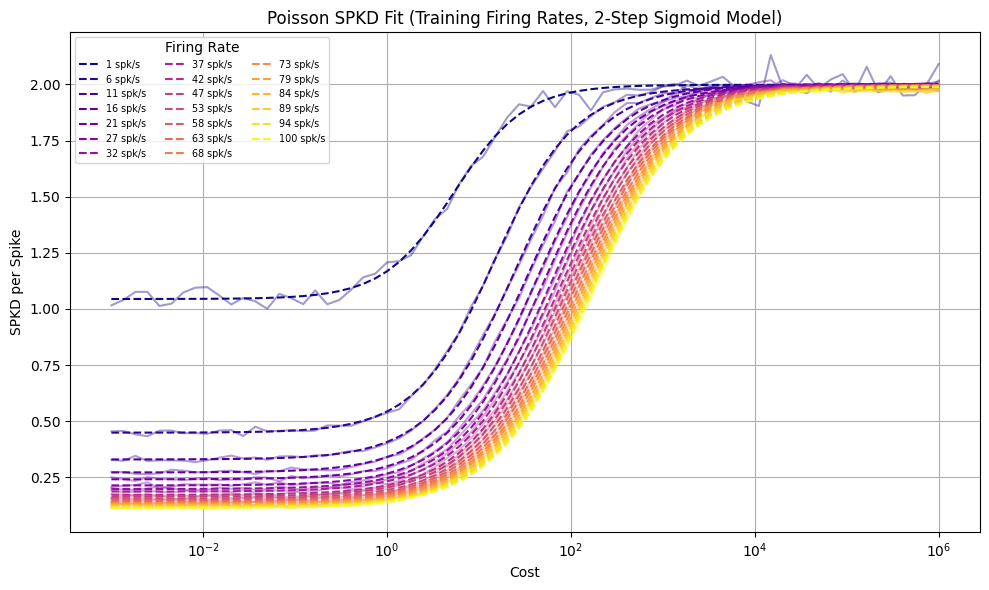

In [7]:
# === Plot training fit with plasma colormap ===
plt.figure(figsize=(10, 6))
cmap = cm.get_cmap("plasma", len(firing_rates))
for i, fr in enumerate(firing_rates):
    color = cmap(i)
    plt.plot(cost_values, spkd_per_spike[:, i], color=color, alpha=0.4)
    plt.plot(cost_values, predicted_grid[i, :], '--', color=color, label=f'{int(fr)} spk/s')
plt.xscale('log')
plt.title('Poisson SPKD Fit (Training Firing Rates, 2-Step Sigmoid Model)')
plt.xlabel('Cost')
plt.ylabel('SPKD per Spike')
plt.legend(ncol=3, fontsize='x-small', title="Firing Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# === Predict for unseen FRs ===
unseen_frs = np.linspace(2, 98, 12)
fr_grid_unseen, cost_grid_unseen = np.meshgrid(unseen_frs, cost_values, indexing='ij')
log_cost_grid_unseen = np.log10(cost_grid_unseen)
predicted_unseen = predict_spkd(log_cost_grid_unseen, fr_grid_unseen)

In [10]:
from tqdm import tqdm
"""
# === Compute actual SPKD for unseen FRs using your Poisson simulator ===
DURATION = 1.0
N = 100
actual_spkd = np.zeros((len(unseen_frs), len(cost_values)))

for i, fr in enumerate(tqdm(unseen_frs, desc="Firing Rates", unit="FR")):
    for j, cost in enumerate(tqdm(cost_values, desc=f"  Cost (FR={fr:.1f})", unit="cost", leave=False)):
        mean_dist, dist_sec, dist_spk = spkdPoisson(fr, cost=cost, duration=DURATION, N=N)
        actual_spkd[i, j] = dist_spk

"""

'\n# === Compute actual SPKD for unseen FRs using your Poisson simulator ===\nDURATION = 1.0\nN = 100\nactual_spkd = np.zeros((len(unseen_frs), len(cost_values)))\n\nfor i, fr in enumerate(tqdm(unseen_frs, desc="Firing Rates", unit="FR")):\n    for j, cost in enumerate(tqdm(cost_values, desc=f"  Cost (FR={fr:.1f})", unit="cost", leave=False)):\n        mean_dist, dist_sec, dist_spk = spkdPoisson(fr, cost=cost, duration=DURATION, N=N)\n        actual_spkd[i, j] = dist_spk\n\n'

In [ ]:
"""
np.savez("actual_spkd_unseen.npz", 
         actual_spkd=actual_spkd, 
         unseen_frs=unseen_frs, 
         cost_values=cost_values, 
         duration=DURATION, 
         N=N)
"""

In [11]:
data = np.load("actual_spkd_unseen.npz")
actual_spkd = data['actual_spkd']
unseen_frs = data['unseen_frs']
cost_values = data['cost_values']
fr_grid_unseen, cost_grid_unseen = np.meshgrid(unseen_frs, cost_values, indexing='ij')
log_cost_grid_unseen = np.log10(cost_grid_unseen)
predicted_unseen = predict_spkd(log_cost_grid_unseen, fr_grid_unseen)

C:\Users\siddu\AppData\Local\Temp\ipykernel_35596\212275336.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_unseen = cm.get_cmap("plasma", len(unseen_frs))


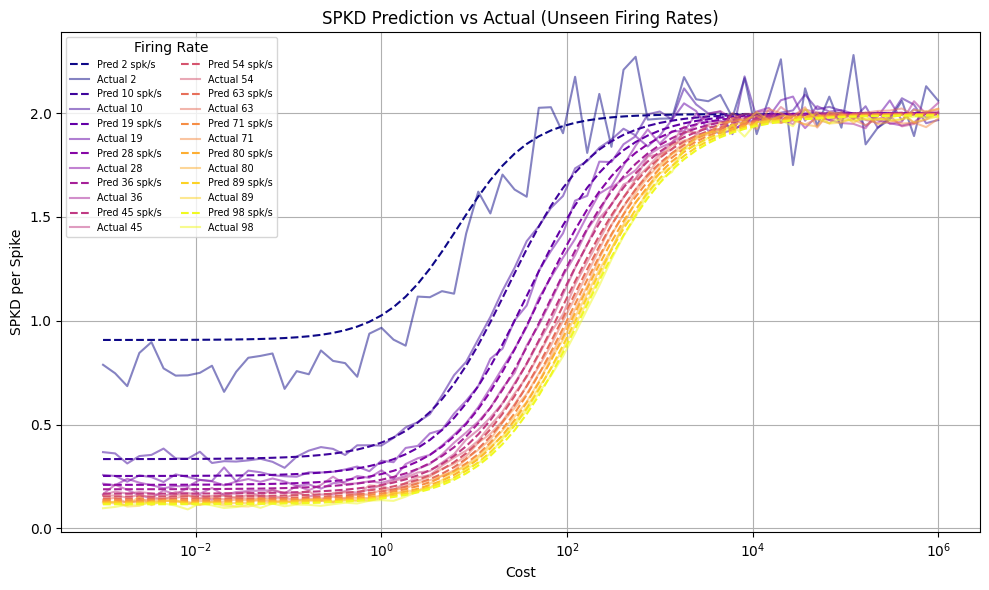

In [12]:
# === Plot actual vs predicted with plasma color coding ===
plt.figure(figsize=(10, 6))
cmap_unseen = cm.get_cmap("plasma", len(unseen_frs))

for i, fr in enumerate(unseen_frs):
    color = cmap_unseen(i)
    plt.plot(cost_values, predicted_unseen[i, :], '--', color=color, label=f'Pred {int(fr)} spk/s')
    plt.plot(cost_values, actual_spkd[i, :], '-', color=color, alpha=0.5, label=f'Actual {int(fr)}')

plt.xscale('log')
plt.title('SPKD Prediction vs Actual (Unseen Firing Rates)')
plt.xlabel('Cost')
plt.ylabel('SPKD per Spike')
plt.legend(ncol=2, fontsize='x-small', title='Firing Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\siddu\AppData\Local\Temp\ipykernel_35596\1741903321.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_unseen = cm.get_cmap("plasma", len(unseen_frs))


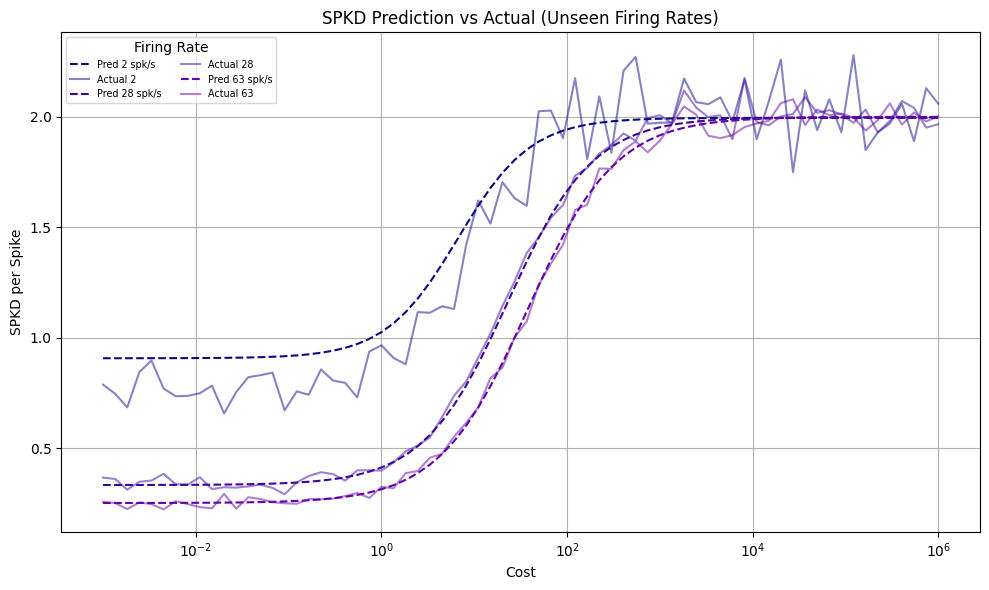

In [13]:
# === Plot actual vs predicted with plasma color coding ===
plt.figure(figsize=(10, 6))
cmap_unseen = cm.get_cmap("plasma", len(unseen_frs))

for i, fr in enumerate(unseen_frs[[0, 3, 7]]):
    color = cmap_unseen(i)
    plt.plot(cost_values, predicted_unseen[i, :], '--', color=color, label=f'Pred {int(fr)} spk/s')
    plt.plot(cost_values, actual_spkd[i, :], '-', color=color, alpha=0.5, label=f'Actual {int(fr)}')

plt.xscale('log')
plt.title('SPKD Prediction vs Actual (Unseen Firing Rates)')
plt.xlabel('Cost')
plt.ylabel('SPKD per Spike')
plt.legend(ncol=2, fontsize='x-small', title='Firing Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
spline_data = np.load('spkd_spline_fits.npz')

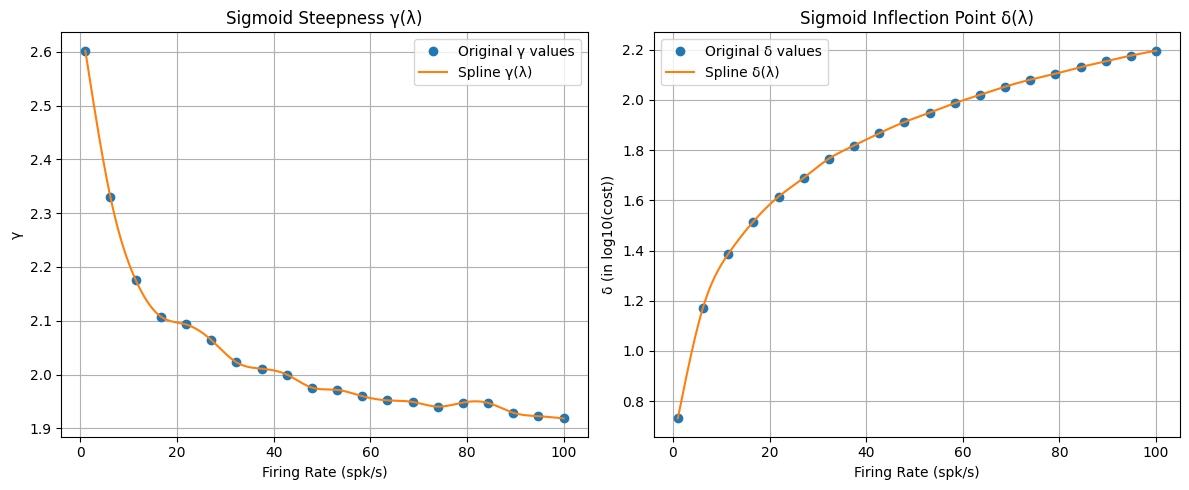

In [15]:
frs = spline_data["frs"]
gamma_vals = spline_data["gamma"]
delta_vals = spline_data["delta"]

# === Fit cubic splines ===
gamma_spline = CubicSpline(frs, gamma_vals, bc_type='natural')
delta_spline = CubicSpline(frs, delta_vals, bc_type='natural')

# === Evaluate on smooth FR range ===
fr_smooth = np.linspace(frs.min(), frs.max(), 500)
gamma_smooth = gamma_spline(fr_smooth)
delta_smooth = delta_spline(fr_smooth)

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frs, gamma_vals, 'o', label='Original γ values')
plt.plot(fr_smooth, gamma_smooth, '-', label='Spline γ(λ)')
plt.title('Sigmoid Steepness γ(λ)')
plt.xlabel('Firing Rate (spk/s)')
plt.ylabel('γ')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(frs, delta_vals, 'o', label='Original δ values')
plt.plot(fr_smooth, delta_smooth, '-', label='Spline δ(λ)')
plt.title('Sigmoid Inflection Point δ(λ)')
plt.xlabel('Firing Rate (spk/s)')
plt.ylabel('δ (in log10(cost))')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\siddu\AppData\Local\Temp\ipykernel_35596\1792268994.py:4: RuntimeWarning: overflow encountered in exp
  def gamma_exp(lmb, a, b, c):     return a * np.exp(-b * lmb) + c
C:\Users\siddu\AppData\Local\Temp\ipykernel_35596\1792268994.py:11: RuntimeWarning: overflow encountered in exp
  def delta_logistic(lmb, L, k, x0): return L / (1 + np.exp(-k * (lmb - x0)))


Best γ(λ): rational — R² = 0.9968
Best δ(λ): log — R² = 1.0000


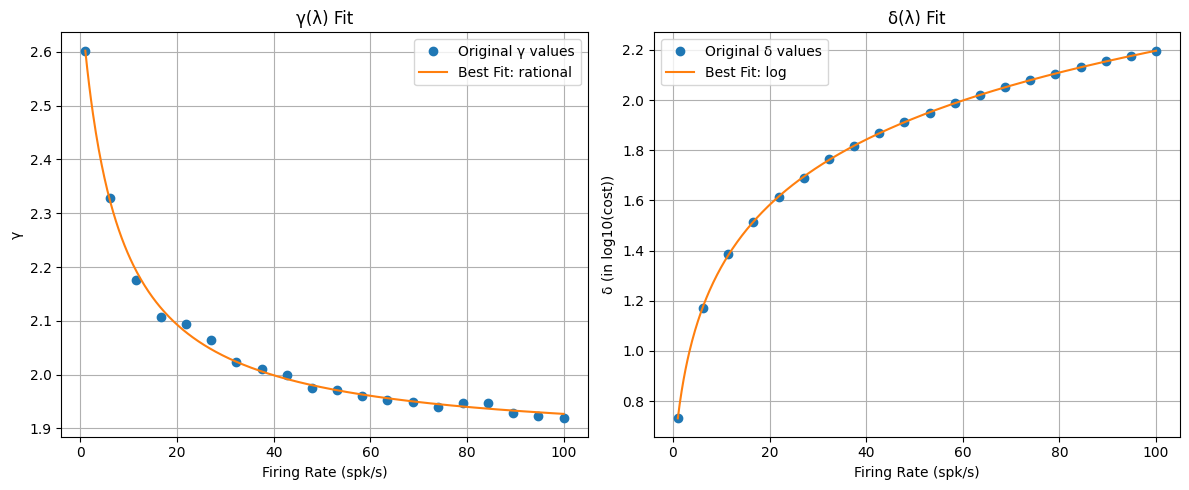

In [19]:
# === Define candidate functions ===

# Gamma candidates (decay)
def gamma_exp(lmb, a, b, c):     return a * np.exp(-b * lmb) + c
def gamma_power(lmb, a, b, c):   return a * lmb**(-b) + c
def gamma_rational(lmb, a, b, c):return a / (lmb + b) + c

# Delta candidates (saturating)
def delta_log(lmb, a, b, c):     return a * np.log(lmb + b) + c
def delta_inverse(lmb, a, b, c): return a - b / (lmb + c)
def delta_logistic(lmb, L, k, x0): return L / (1 + np.exp(-k * (lmb - x0)))

models = {
    "gamma": {
        "exp": gamma_exp,
        "power": gamma_power,
        "rational": gamma_rational,
    },
    "delta": {
        "log": delta_log,
        "inverse": delta_inverse,
        "logistic": delta_logistic,
    }
}

# === Fit all models ===
results = {}
for param, funcs in models.items():
    y = gamma_vals if param == "gamma" else delta_vals
    results[param] = {}
    for name, func in funcs.items():
        try:
            popt, _ = curve_fit(func, frs, y, maxfev=10000)
            y_pred = func(frs, *popt)
            mse = mean_squared_error(y, y_pred)
            r2 = r2_score(y, y_pred)
            results[param][name] = {
                "func": func,
                "popt": popt,
                "mse": mse,
                "r2": r2,
            }
        except Exception as e:
            results[param][name] = {"error": str(e)}

# === Select best models by R² ===
best_gamma = max(results["gamma"].items(), key=lambda kv: kv[1].get("r2", -np.inf))
best_delta = max(results["delta"].items(), key=lambda kv: kv[1].get("r2", -np.inf))

print(f"Best γ(λ): {best_gamma[0]} — R² = {best_gamma[1]['r2']:.4f}")
print(f"Best δ(λ): {best_delta[0]} — R² = {best_delta[1]['r2']:.4f}")

# === Plot ===
fr_smooth = np.linspace(frs.min(), frs.max(), 500)
gamma_fit = best_gamma[1]['func'](fr_smooth, *best_gamma[1]['popt'])
delta_fit = best_delta[1]['func'](fr_smooth, *best_delta[1]['popt'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frs, gamma_vals, 'o', label='Original γ values')
plt.plot(fr_smooth, gamma_fit, '-', label=f'Best Fit: {best_gamma[0]}')
plt.title('γ(λ) Fit')
plt.xlabel('Firing Rate (spk/s)')
plt.ylabel('γ')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(frs, delta_vals, 'o', label='Original δ values')
plt.plot(fr_smooth, delta_fit, '-', label=f'Best Fit: {best_delta[0]}')
plt.title('δ(λ) Fit')
plt.xlabel('Firing Rate (spk/s)')
plt.ylabel('δ (in log10(cost))')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('best_fit_gamma_delta.png', dpi=300)
plt.show()


In [18]:
results

{'gamma': {'exp': {'func': <function __main__.gamma_exp(lmb, a, b, c)>,
   'popt': array([0.6736476 , 0.08016477, 1.95000039]),
   'mse': 0.0005468608443253975,
   'r2': 0.9792798726285157},
  'power': {'func': <function __main__.gamma_power(lmb, a, b, c)>,
   'popt': array([1.42002568, 0.14876059, 1.19343179]),
   'mse': 0.000258316579436889,
   'r2': 0.9902125879304796},
  'rational': {'func': <function __main__.gamma_rational(lmb, a, b, c)>,
   'popt': array([6.07439536, 7.2989428 , 1.87028317]),
   'mse': 8.402039762303674e-05,
   'r2': 0.9968165332028852}},
 'delta': {'log': {'func': <function __main__.delta_log(lmb, a, b, c)>,
   'popt': array([0.39594976, 1.50604787, 0.36739907]),
   'mse': 5.266649030419785e-06,
   'r2': 0.999961297168315},
  'inverse': {'func': <function __main__.delta_inverse(lmb, a, b, c)>,
   'popt': array([ 2.44655749, 34.32340415, 19.56143262]),
   'mse': 0.0007524964148365334,
   'r2': 0.9944701570355791},
  'logistic': {'func': <function __main__.delta_

In [ ]:
"""
params_dict = {
    "gamma": {
        "func": "rational",
        "params": list(best_gamma[1]["popt"])
    },
    "delta": {
        "func": "log",
        "params": list(best_delta[1]["popt"])
    }
}

with open("spkd_shape_params.json", "w") as f:
    json.dump(params_dict, f, indent=4)

"""